In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

tfd = tfp.distributions
tfb = tfp.bijectors


In [2]:
#@title Utils { display-mode: "form" }
def print_subclasses_from_module(module, base_class, maxwidth=80):
  import functools, inspect, sys
  subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
  def red(acc, x):
    if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
      acc.append(x)
    else:
      acc[-1] += ", " + x
    return acc
  print('\n'.join(functools.reduce(red, subclasses, [])))


In [3]:
# Tensorflow

mats = tf.random.uniform(shape=[1000, 10, 10])
vecs = tf.random.uniform(shape=[1000, 10, 1])

def for_loop_solve():
  return np.array(
    [tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(1000)])

def vectorized_solve():
  return tf.linalg.solve(mats, vecs)

# Vectorization for the win!
%timeit for_loop_solve()
%timeit vectorized_solve()


452 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
876 µs ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
# Code can run seamlessly on a GPU, just change Colab runtime type
# in the 'Runtime' menu.
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")


Using a CPU


In [5]:
# Differentiation
a = tf.constant(np.pi)
b = tf.constant(np.e)
with tf.GradientTape() as tape:
  tape.watch([a, b])
  c = .5 * (a**2 + b**2)
grads = tape.gradient(c, [a, b])
print(grads[0])
print(grads[1])


tf.Tensor(3.1415927, shape=(), dtype=float32)
tf.Tensor(2.7182817, shape=(), dtype=float32)


In [6]:
# Probability

In [7]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)


tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


In [8]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)


tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


/home/olethros/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


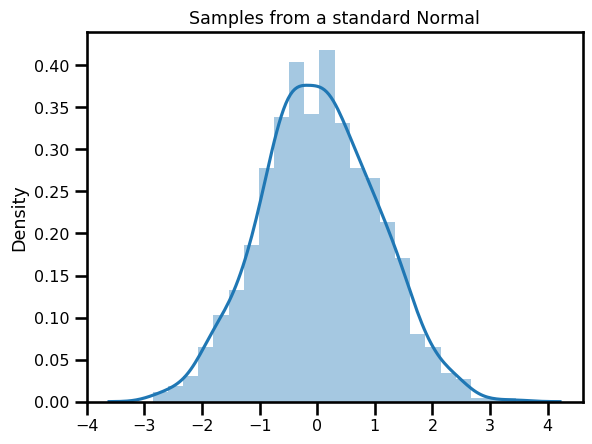

In [9]:
# Plot 1000 samples from a standard normal
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()


In [10]:
# Compute the log_prob of a point in the event space of `normal`
print(normal.log_prob(0.).numpy(), normal.prob(0.).numpy())

-0.9189385 0.3989423


In [11]:
# Compute the log_prob of a few points
normal.log_prob([-1., 0., 1.])


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

# Distributions and Shapes
Numpy ndarrays and TensorFlow Tensors have shapes.

TensorFlow Probability Distributions have shape semantics -- we partition shapes into semantically distinct pieces, even though the same chunk of memory (Tensor/ndarray) is used for the whole everything.

- Batch shape denotes a collection of Distributions with distinct parameters
- Event shape denotes the shape of samples from the Distribution.
We always put batch shapes on the "left" and event shapes on the "right".


In [12]:
# Create a batch of 3 normals, and plot 1000 samples from each
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadacasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [13]:
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)
samples

Shape of samples: (1000, 3)


<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
array([[-1.1482924 ,  0.69487417,  1.9155538 ],
       [-1.3140244 ,  1.4585482 ,  2.7318993 ],
       [-2.4769204 , -2.1219256 ,  1.7059503 ],
       ...,
       [-3.0160093 ,  1.4741412 ,  2.4552593 ],
       [-4.258073  ,  0.8613848 ,  2.8762343 ],
       [-3.6828578 , -0.67014056,  2.2843769 ]], dtype=float32)>

In [14]:
# Sample shapes can themselves be more complicated
print("Shape of samples:", normals.sample([10, 10, 10]).shape)
normals.sample([2, 4])

Shape of samples: (10, 10, 10, 3)


<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[-1.9349604 ,  0.09762566,  2.4686766 ],
        [-3.3260617 ,  0.22688216,  1.6328514 ],
        [-3.4484093 , -0.03929198,  1.4615431 ],
        [-0.6229147 , -0.81767505,  1.8785105 ]],

       [[-2.9484148 , -0.741434  ,  3.1664279 ],
        [-3.5732608 , -0.31272128,  3.0215924 ],
        [-5.2660484 ,  0.09823485,  3.29486   ],
        [-0.9579979 , -0.30018443,  2.0016448 ]]], dtype=float32)>

In [15]:
# A batch of normals gives a batch of log_probs.
print(normals.log_prob([-2.5, 0.0, 2.5]))


tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [16]:
# But this would work:
a = np.zeros([200, 1]) + np.zeros(3)
print("Broadcast shape:", a.shape)


Broadcast shape: (200, 3)


In [17]:
# And so will this!
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
# => shape = [200, 1]

lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)


Broadcast log_prob shape: (200, 3)


In [18]:
# And so will this!
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
# => shape = [200, 1]
print(np.tile(xs, 3).shape)
lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)


(200, 3)
Broadcast log_prob shape: (200, 3)


/home/olethros/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


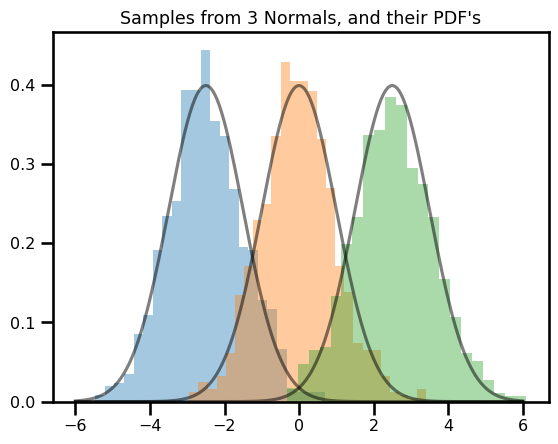

In [19]:
# Summarizing visually
for i in range(3):
  sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()


In [20]:
# Simple Inference
theta_true = 0.7
true_p = np.array([1-theta_true, theta_true])
num_examples = 128
xs = np.random.choice(2, p=true_p, size=num_examples).astype(np.float32)

In [21]:
def joint_log_prob_Beta_Bernoulli(p, x):
    # w ~ Beta(1,1)
    # x_i ~ Bernoulli(w)
    
    rv_p = tfd.Beta(concentration0=1, concentration1=1)
    rv_x = tfd.Bernoulli(probs=p)
    return (rv_p.log_prob(p) + tf.reduce_sum(rv_x.log_prob(x)))

X = tfd.Bernoulli(probs=0.7)
P = tfd.Beta(concentration0=1, concentration1=1)
print(P.log_prob(0.7))
print(tf.reduce_sum(X.log_prob(xs)))
print(P.log_prob(0.7) +tf.reduce_sum(X.log_prob(xs)))


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(-72.76793, shape=(), dtype=float32)
tf.Tensor(-72.76793, shape=(), dtype=float32)


In [22]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior_Beta_Bernoulli(p):
  return joint_log_prob_Beta_Bernoulli(p, xs)

In [23]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior_Beta_Bernoulli,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [24]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [25]:
initial_state = [0.5]

Acceptance rate: 0.058


/home/olethros/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


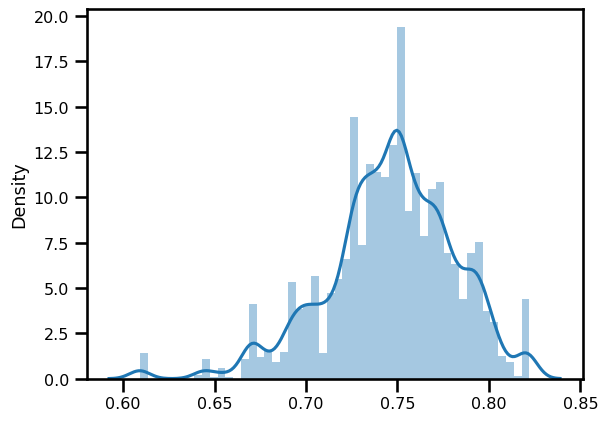

In [26]:
samples, kernel_results = run_chain(initial_state, num_results=10000,num_burnin_steps=1000)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())
# Trace plots
# Histogram of samples
sns.distplot(samples)
plt.show()


In [27]:
np.mean(xs)

0.75